In this notebook we implement the stage 1 of the phononet architecture in tensorflow. We use the phononet library to just extract the chromogram data.

In [1]:
import sys

In [2]:
sys.path.append('../')

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
import json

import phononet as pn

In [5]:
include_files = json.load(open('SankalpRagaDataset.json'))  # import list of song_ids to include
cd = pn.FullChromaDataset('hindustaniv2.json', '../../n_ftt4096__hop_length2048',
                          include_mbids=include_files)  # load dataset of "full song" chromagrams
train, test = cd.train_test_split(train_size=0.75)  # split training and test sets from "full song" chromagrams
train = pn.ChromaChunkDataset(train, chunk_size=1500)  # divide training set into chunks of width 150
test = pn.ChromaChunkDataset(test, chunk_size=1500)

Loading Chromagram Files: 100%|██████████| 300/300 [00:01<00:00, 194.45it/s]


In [6]:
#raga_detector = pn.RagaDetector(batch_size=32, gpus=1)
#raga_detector.fit(train, test)

In [7]:
from tensorflow import keras

In [8]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [9]:
import numpy as np

In [10]:
X_train=train.X.numpy()
y_train=np.array(train.y).astype(np.int8)

X_val=test.X.numpy()
y_val=np.array(test.y)[...,np.newaxis].astype(np.int8)

In [11]:

def gen():
    n=len(X_train)
    l=list(range(12))
    for idx in range(n):
        for i in range(12):
            yield X_train[idx].take(l[i:]+l[:i],axis=0),y_train[idx]
            
            
        

In [51]:
BATCH_SIZE=32
#train_data=tf.data.Dataset.from_generator(generator=gen,
#                                           output_shapes=(tf.TensorShape([12,1500]),tf.TensorShape([])),
#                                           output_types=(tf.float32,tf.int8)
#                                          ).shuffle(1000).repeat().batch(BATCH_SIZE)
train_data=tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(1000).batch(BATCH_SIZE)
val_data=tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(1000).batch(BATCH_SIZE)

In [52]:
class ConfusionMatrixMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the running average of the confusion matrix
    """
    def __init__(self, size, **kwargs):
        super(ConfusionMatrixMetric,self).__init__(**kwargs) # handles base args (e.g., dtype)
        self.size=size
        self.total_cm = self.add_weight("total", shape=(size,size), initializer="zeros")
        
    def reset_states(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))
            
    def update_state(self, y_true, y_pred,sample_weight=None):
        self.total_cm.assign_add(self.confusion_matrix(y_true,y_pred))
        return self.total_cm
        
    def result(self):
        return self.process_confusion_matrix()
    
    def confusion_matrix(self,y_true, y_pred):
        """
        Make a confusion matrix
        """
        y_pred=tf.argmax(y_pred,1)
        cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=self.size)
        return cm
    
    def process_confusion_matrix(self):
        "returns precision, recall and f1 along with overall accuracy"
        cm=self.total_cm
        diag_part=tf.linalg.diag_part(cm)
        precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
        recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
        f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
        return precision,recall,f1
    


In [53]:
class MySequential(keras.Sequential):
    
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
    
    def train_step(self, data):
            # Unpack the data. Its structure depends on your model and
            # on what you pass to `fit()`.
            
            x, y = data

            with tf.GradientTape() as tape:
                y_pred = self(x, training=True)  # Forward pass
                # Compute the loss value.
                # The loss function is configured in `compile()`.
                loss = self.compiled_loss(
                    y,
                    y_pred,
                    regularization_losses=self.losses,
                )

            # Compute gradients
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)

            # Update weights
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            self.compiled_metrics.update_state(y, y_pred)
            #self.confusion_matrix_metric.update_state(y, y_pred)
            output={m.name: m.result() for m in self.metrics[:-1]}
            results = self.metrics[-1].result()
            for i in range(30):
                output['F1_{}'.format(i)]=results[2][i]
            return output
        
        
    def test_step(self, data):
            # Unpack the data. Its structure depends on your model and
            # on what you pass to `fit()`.
            
            x, y = data

            y_pred = self(x, training=False)  # Forward pass
            # Compute the loss value.
            # The loss function is configured in `compile()`.
            loss = self.compiled_loss(
                y,
                y_pred,
                regularization_losses=self.losses,
            )

            self.compiled_metrics.update_state(y, y_pred)
            #self.confusion_matrix_metric.update_state(y, y_pred)
            output={m.name: m.result() for m in self.metrics[:-1]}
            results = self.metrics[-1].result()
            for i in range(30):
                output['F1_{}'.format(i)]=results[2][i]
            return output
            


In [54]:
from tensorflow.keras.models import Sequential

In [55]:
class PeriodicPaddingConv2D(keras.layers.Conv2D):
    
    # Note this ONLY works now for filter size 3 and stride of 1
    
    def __init__(self,*args,**kwargs):
        padding_val=kwargs.pop('padding',None)
        if padding_val=='same':
            print('For PeriodPaddingConv2D padding must be valid so setting it to valid.')
            
            # TODO: padding is the same in all directions and we thus loose length in the time direction
            # Should not be a big deal but we can change this by padding zeros explicitely.
            kwargs['padding']='valid'
        super().__init__(*args,**kwargs)
            
    def call(self,x):
        pre=tf.constant(np.diag(np.ones(12)).take([11,0,1,2,3,4,5,6,7,8,9,10,11,0],axis=0),dtype=np.float32)
        x=tf.transpose(tf.tensordot(pre,x,axes=[1,1]),(1,0,2,3))
        return super().call(x)
    



In [56]:
model=MySequential([
    keras.layers.Input(shape=(12,1500)),
    keras.layers.Lambda(lambda x: tf.expand_dims(x,-1)),
    keras.layers.BatchNormalization(name='bn0',axis=[3]),
    #
    PeriodicPaddingConv2D(64,(3,3),padding='valid'),
    keras.layers.Activation(keras.activations.elu),
    keras.layers.BatchNormalization(name='bn1',axis=[3]), # batch normalization on everything but last dimension
    keras.layers.MaxPool2D((1,2)),
    keras.layers.Dropout(.2),
    #
    PeriodicPaddingConv2D(128,(3,3),padding='valid'),
    keras.layers.Activation(keras.activations.elu),
    keras.layers.BatchNormalization(name='bn2',axis=[3]),
    keras.layers.MaxPool2D((1,3)),
    keras.layers.Dropout(.2),
    #
    PeriodicPaddingConv2D(150,(3,3),padding='valid'),
    keras.layers.Activation(keras.activations.elu),
    keras.layers.BatchNormalization(name='bn3',axis=[3]),
    keras.layers.MaxPool2D((1,2)),
    keras.layers.Dropout(.2),
    #
    PeriodicPaddingConv2D(200,(3,3),padding='valid'),
    keras.layers.Activation(keras.activations.elu),
    keras.layers.BatchNormalization(name='bn4',axis=[3]),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(.2),
    keras.layers.Dense(30)

])

model.summary()

Model: "my_sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 12, 1500, 1)       0         
_________________________________________________________________
bn0 (BatchNormalization)     (None, 12, 1500, 1)       4         
_________________________________________________________________
periodic_padding_conv2d_12 ( (None, 12, 1498, 64)      640       
_________________________________________________________________
activation_12 (Activation)   (None, 12, 1498, 64)      0         
_________________________________________________________________
bn1 (BatchNormalization)     (None, 12, 1498, 64)      256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 749, 64)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 12, 749, 64)   

In [57]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy',ConfusionMatrixMetric(30)])

In [58]:
history=model.fit(train_data,validation_data=val_data,epochs=100)#,steps_per_epoch=len(X_train)//BATCH_SIZE)

Epoch 1/100
74/74 [==============================] - 17s 232ms/step - loss: 3.3566 - accuracy: 0.0886 - F1_0: 0.0164 - F1_1: 0.0000e+00 - F1_2: 0.0000e+00 - F1_3: 0.0615 - F1_4: 0.0019 - F1_5: 0.0574 - F1_6: 0.0672 - F1_7: 0.0028 - F1_8: 0.1187 - F1_9: 0.1178 - F1_10: 0.0090 - F1_11: 0.0202 - F1_12: 0.0848 - F1_13: 0.0000e+00 - F1_14: 7.5001e-04 - F1_15: 0.0536 - F1_16: 0.0934 - F1_17: 0.0539 - F1_18: 0.0119 - F1_19: 0.0000e+00 - F1_20: 0.0703 - F1_21: 0.1053 - F1_22: 0.0687 - F1_23: 0.1381 - F1_24: 0.0000e+00 - F1_25: 0.0589 - F1_26: 0.1710 - F1_27: 0.0000e+00 - F1_28: 0.0918 - F1_29: 0.0000e+00 - val_loss: 6.3558 - val_accuracy: 0.0627 - val_F1_0: 0.0000e+00 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0000e+00 - val_F1_4: 0.0000e+00 - val_F1_5: 0.0000e+00 - val_F1_6: 0.0000e+00 - val_F1_7: 0.0000e+00 - val_F1_8: 0.0000e+00 - val_F1_9: 0.0000e+00 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0000e+00 - va

74/74 [==============================] - 17s 225ms/step - loss: 1.4283 - accuracy: 0.6370 - F1_0: 0.5439 - F1_1: 0.0706 - F1_2: 0.4212 - F1_3: 0.5427 - F1_4: 0.7238 - F1_5: 0.6174 - F1_6: 0.7834 - F1_7: 0.6397 - F1_8: 0.7690 - F1_9: 0.4825 - F1_10: 0.6522 - F1_11: 0.1632 - F1_12: 0.5588 - F1_13: 0.5721 - F1_14: 0.5499 - F1_15: 0.6018 - F1_16: 0.5953 - F1_17: 0.5988 - F1_18: 0.5235 - F1_19: 0.7202 - F1_20: 0.7073 - F1_21: 0.6449 - F1_22: 0.5986 - F1_23: 0.6327 - F1_24: 0.4615 - F1_25: 0.4359 - F1_26: 0.7433 - F1_27: 0.3958 - F1_28: 0.5935 - F1_29: 0.5327 - val_loss: 3.3170 - val_accuracy: 0.2125 - val_F1_0: 0.0000e+00 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.4789 - val_F1_4: 0.0000e+00 - val_F1_5: 0.0000e+00 - val_F1_6: 0.0000e+00 - val_F1_7: 0.1818 - val_F1_8: 0.8333 - val_F1_9: 0.2192 - val_F1_10: 0.4054 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0000e+00 - val_F1_15: 0.0000e+00 - val_F1_16: 0.2500 - val_F1_17: 0.0000e+00 

Epoch 14/100
74/74 [==============================] - 17s 225ms/step - loss: 0.5198 - accuracy: 0.8914 - F1_0: 0.8559 - F1_1: 0.8318 - F1_2: 0.7449 - F1_3: 0.8714 - F1_4: 0.8576 - F1_5: 0.8703 - F1_6: 0.9419 - F1_7: 0.8543 - F1_8: 0.9331 - F1_9: 0.8339 - F1_10: 0.9249 - F1_11: 0.6877 - F1_12: 0.8827 - F1_13: 0.8820 - F1_14: 0.8776 - F1_15: 0.8592 - F1_16: 0.8229 - F1_17: 0.7402 - F1_18: 0.7801 - F1_19: 0.9179 - F1_20: 0.9078 - F1_21: 0.9228 - F1_22: 0.8808 - F1_23: 0.8999 - F1_24: 0.8267 - F1_25: 0.8569 - F1_26: 0.9337 - F1_27: 0.8228 - F1_28: 0.8667 - F1_29: 0.9365 - val_loss: 2.4774 - val_accuracy: 0.3892 - val_F1_0: 0.4286 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.2069 - val_F1_4: 0.6341 - val_F1_5: 0.7778 - val_F1_6: 0.0625 - val_F1_7: 0.1429 - val_F1_8: 0.7273 - val_F1_9: 0.1558 - val_F1_10: 0.2759 - val_F1_11: 0.0000e+00 - val_F1_12: 0.6279 - val_F1_13: 0.4000 - val_F1_14: 0.1569 - val_F1_15: 0.4776 - val_F1_16: 0.6154 - val_F1_17: 0.0000e+00 - val_F1_18: 0.5652

Epoch 21/100
74/74 [==============================] - 17s 224ms/step - loss: 0.2675 - accuracy: 0.9517 - F1_0: 0.8833 - F1_1: 0.8057 - F1_2: 0.8539 - F1_3: 0.8579 - F1_4: 0.8489 - F1_5: 0.9397 - F1_6: 0.9795 - F1_7: 0.8704 - F1_8: 0.9735 - F1_9: 0.8907 - F1_10: 0.9647 - F1_11: 0.9075 - F1_12: 0.9611 - F1_13: 0.9725 - F1_14: 0.7684 - F1_15: 0.9280 - F1_16: 0.9087 - F1_17: 0.9195 - F1_18: 0.9139 - F1_19: 0.9540 - F1_20: 0.9566 - F1_21: 0.9636 - F1_22: 0.9134 - F1_23: 0.9885 - F1_24: 0.8914 - F1_25: 0.9640 - F1_26: 0.9542 - F1_27: 0.8659 - F1_28: 0.9143 - F1_29: 0.9425 - val_loss: 3.3562 - val_accuracy: 0.3560 - val_F1_0: 0.0667 - val_F1_1: 0.2857 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0000e+00 - val_F1_4: 0.4286 - val_F1_5: 0.1053 - val_F1_6: 0.6400 - val_F1_7: 0.0000e+00 - val_F1_8: 0.5556 - val_F1_9: 0.2609 - val_F1_10: 0.5470 - val_F1_11: 0.0000e+00 - val_F1_12: 0.3390 - val_F1_13: 0.4211 - val_F1_14: 0.4118 - val_F1_15: 0.1788 - val_F1_16: 0.5000 - val_F1_17: 0.4490 - val_F1_18: 0.0833

Epoch 28/100
74/74 [==============================] - 17s 225ms/step - loss: 0.1717 - accuracy: 0.9720 - F1_0: 0.9726 - F1_1: 0.9461 - F1_2: 0.9497 - F1_3: 0.9511 - F1_4: 0.9429 - F1_5: 0.9457 - F1_6: 0.9936 - F1_7: 0.9663 - F1_8: 0.9784 - F1_9: 0.9615 - F1_10: 0.9662 - F1_11: 0.9038 - F1_12: 0.9729 - F1_13: 0.9918 - F1_14: 0.8100 - F1_15: 0.9924 - F1_16: 0.9591 - F1_17: 0.9687 - F1_18: 0.9795 - F1_19: 0.9685 - F1_20: 0.9874 - F1_21: 0.9968 - F1_22: 0.9504 - F1_23: 0.9993 - F1_24: 0.9694 - F1_25: 0.9921 - F1_26: 0.9839 - F1_27: 0.9531 - F1_28: 0.9654 - F1_29: 0.9420 - val_loss: 1.9534 - val_accuracy: 0.4802 - val_F1_0: 0.4878 - val_F1_1: 0.2632 - val_F1_2: 0.0952 - val_F1_3: 0.5405 - val_F1_4: 0.7333 - val_F1_5: 0.5614 - val_F1_6: 0.6897 - val_F1_7: 0.0000e+00 - val_F1_8: 0.8333 - val_F1_9: 0.6190 - val_F1_10: 0.7143 - val_F1_11: 0.2500 - val_F1_12: 0.5120 - val_F1_13: 0.3030 - val_F1_14: 0.4375 - val_F1_15: 0.3846 - val_F1_16: 0.6667 - val_F1_17: 0.2000 - val_F1_18: 0.4286 - val_F1_19

Epoch 35/100
74/74 [==============================] - 17s 225ms/step - loss: 0.1175 - accuracy: 0.9826 - F1_0: 0.9791 - F1_1: 0.9060 - F1_2: 0.9961 - F1_3: 0.9494 - F1_4: 0.9573 - F1_5: 0.9461 - F1_6: 1.0000 - F1_7: 0.9300 - F1_8: 0.9923 - F1_9: 0.9604 - F1_10: 0.9785 - F1_11: 0.9915 - F1_12: 0.9810 - F1_13: 0.9821 - F1_14: 0.9109 - F1_15: 0.9942 - F1_16: 0.9616 - F1_17: 0.9867 - F1_18: 0.8977 - F1_19: 0.9434 - F1_20: 0.9845 - F1_21: 0.9744 - F1_22: 0.9751 - F1_23: 0.9988 - F1_24: 0.9730 - F1_25: 0.9745 - F1_26: 0.9830 - F1_27: 0.9967 - F1_28: 0.9990 - F1_29: 0.9916 - val_loss: 2.7352 - val_accuracy: 0.4379 - val_F1_0: 0.4186 - val_F1_1: 0.1111 - val_F1_2: 0.5000 - val_F1_3: 0.0000e+00 - val_F1_4: 0.7778 - val_F1_5: 0.5185 - val_F1_6: 0.6486 - val_F1_7: 0.0000e+00 - val_F1_8: 0.6087 - val_F1_9: 0.5000 - val_F1_10: 0.4590 - val_F1_11: 0.0000e+00 - val_F1_12: 0.8475 - val_F1_13: 0.1474 - val_F1_14: 0.5682 - val_F1_15: 0.7586 - val_F1_16: 0.5000 - val_F1_17: 0.0000e+00 - val_F1_18: 0.6061

Epoch 42/100
74/74 [==============================] - 17s 224ms/step - loss: 0.0866 - accuracy: 0.9830 - F1_0: 0.9673 - F1_1: 0.9529 - F1_2: 0.9343 - F1_3: 0.9867 - F1_4: 0.9084 - F1_5: 0.9914 - F1_6: 0.9733 - F1_7: 0.9790 - F1_8: 0.9783 - F1_9: 0.9670 - F1_10: 0.9640 - F1_11: 0.9816 - F1_12: 0.9991 - F1_13: 0.9812 - F1_14: 0.9249 - F1_15: 0.9766 - F1_16: 0.9835 - F1_17: 0.9858 - F1_18: 0.9684 - F1_19: 0.8872 - F1_20: 0.9936 - F1_21: 1.0000 - F1_22: 0.9893 - F1_23: 1.0000 - F1_24: 0.9131 - F1_25: 0.9682 - F1_26: 0.9861 - F1_27: 0.9712 - F1_28: 0.9954 - F1_29: 0.9735 - val_loss: 3.8856 - val_accuracy: 0.2638 - val_F1_0: 0.1622 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0937 - val_F1_3: 0.3125 - val_F1_4: 0.7059 - val_F1_5: 0.5818 - val_F1_6: 0.1143 - val_F1_7: 0.2105 - val_F1_8: 0.1207 - val_F1_9: 0.2609 - val_F1_10: 0.1200 - val_F1_11: 0.1111 - val_F1_12: 0.1579 - val_F1_13: 0.2667 - val_F1_14: 0.2143 - val_F1_15: 0.3158 - val_F1_16: 0.0779 - val_F1_17: 0.2632 - val_F1_18: 0.1176 - val_F1_19

Epoch 49/100
74/74 [==============================] - 17s 225ms/step - loss: 0.0581 - accuracy: 0.9902 - F1_0: 0.9984 - F1_1: 0.9084 - F1_2: 0.9867 - F1_3: 0.9733 - F1_4: 0.9597 - F1_5: 0.9644 - F1_6: 0.9867 - F1_7: 0.9833 - F1_8: 0.9953 - F1_9: 0.9913 - F1_10: 0.9812 - F1_11: 0.9776 - F1_12: 0.9693 - F1_13: 0.9900 - F1_14: 0.9829 - F1_15: 1.0000 - F1_16: 0.9693 - F1_17: 1.0000 - F1_18: 0.9528 - F1_19: 0.9911 - F1_20: 0.9984 - F1_21: 1.0000 - F1_22: 0.9980 - F1_23: 0.9965 - F1_24: 0.9893 - F1_25: 0.9733 - F1_26: 0.9852 - F1_27: 0.9622 - F1_28: 1.0000 - F1_29: 1.0000 - val_loss: 4.1946 - val_accuracy: 0.2919 - val_F1_0: 0.1875 - val_F1_1: 0.1250 - val_F1_2: 0.0000e+00 - val_F1_3: 0.2581 - val_F1_4: 0.6471 - val_F1_5: 0.5333 - val_F1_6: 0.4124 - val_F1_7: 0.0000e+00 - val_F1_8: 0.8000 - val_F1_9: 0.3889 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0556 - val_F1_13: 0.2222 - val_F1_14: 0.2951 - val_F1_15: 0.0000e+00 - val_F1_16: 0.3636 - val_F1_17: 0.0000e+00 - val_F1_18

Epoch 56/100
74/74 [==============================] - 17s 224ms/step - loss: 0.0786 - accuracy: 0.9839 - F1_0: 0.9862 - F1_1: 0.9575 - F1_2: 0.9733 - F1_3: 0.9138 - F1_4: 0.9205 - F1_5: 0.9652 - F1_6: 0.9861 - F1_7: 0.9780 - F1_8: 0.9873 - F1_9: 0.9011 - F1_10: 0.9734 - F1_11: 0.9598 - F1_12: 0.9288 - F1_13: 0.9682 - F1_14: 0.9619 - F1_15: 0.9893 - F1_16: 0.9710 - F1_17: 0.9906 - F1_18: 0.9510 - F1_19: 0.9841 - F1_20: 0.9400 - F1_21: 0.9867 - F1_22: 0.9805 - F1_23: 0.9831 - F1_24: 0.9867 - F1_25: 0.9981 - F1_26: 0.9934 - F1_27: 0.9575 - F1_28: 0.9841 - F1_29: 0.9931 - val_loss: 3.2952 - val_accuracy: 0.3777 - val_F1_0: 0.4444 - val_F1_1: 0.2647 - val_F1_2: 0.0000e+00 - val_F1_3: 0.5714 - val_F1_4: 0.5238 - val_F1_5: 0.3218 - val_F1_6: 0.0000e+00 - val_F1_7: 0.1667 - val_F1_8: 0.7500 - val_F1_9: 0.3696 - val_F1_10: 0.4688 - val_F1_11: 0.0000e+00 - val_F1_12: 0.6957 - val_F1_13: 0.1429 - val_F1_14: 0.1569 - val_F1_15: 0.4762 - val_F1_16: 0.3158 - val_F1_17: 0.0000e+00 - val_F1_18: 0.6400

Epoch 63/100
74/74 [==============================] - 17s 224ms/step - loss: 0.0410 - accuracy: 0.9932 - F1_0: 0.9859 - F1_1: 0.9713 - F1_2: 0.9600 - F1_3: 0.9852 - F1_4: 0.9950 - F1_5: 0.9984 - F1_6: 0.9867 - F1_7: 0.9665 - F1_8: 0.9924 - F1_9: 0.9929 - F1_10: 0.9753 - F1_11: 0.9642 - F1_12: 0.9701 - F1_13: 1.0000 - F1_14: 0.9733 - F1_15: 1.0000 - F1_16: 0.9631 - F1_17: 0.9867 - F1_18: 0.9967 - F1_19: 1.0000 - F1_20: 0.9970 - F1_21: 1.0000 - F1_22: 0.9363 - F1_23: 0.9925 - F1_24: 0.9733 - F1_25: 1.0000 - F1_26: 1.0000 - F1_27: 0.9787 - F1_28: 1.0000 - F1_29: 0.9600 - val_loss: 3.7034 - val_accuracy: 0.3163 - val_F1_0: 0.0667 - val_F1_1: 0.1250 - val_F1_2: 0.1250 - val_F1_3: 0.3429 - val_F1_4: 0.0741 - val_F1_5: 0.6471 - val_F1_6: 0.0625 - val_F1_7: 0.0789 - val_F1_8: 0.4000 - val_F1_9: 0.5333 - val_F1_10: 0.0000e+00 - val_F1_11: 0.3509 - val_F1_12: 0.6849 - val_F1_13: 0.2353 - val_F1_14: 0.3939 - val_F1_15: 0.4110 - val_F1_16: 0.5455 - val_F1_17: 0.1875 - val_F1_18: 0.2062 - val_F1_19

Epoch 70/100
74/74 [==============================] - 17s 224ms/step - loss: 0.0316 - accuracy: 0.9953 - F1_0: 0.9934 - F1_1: 0.9681 - F1_2: 0.9200 - F1_3: 0.9733 - F1_4: 0.9867 - F1_5: 0.9876 - F1_6: 0.9812 - F1_7: 0.9809 - F1_8: 0.9927 - F1_9: 0.9692 - F1_10: 0.9910 - F1_11: 0.9720 - F1_12: 0.9862 - F1_13: 1.0000 - F1_14: 0.9648 - F1_15: 1.0000 - F1_16: 0.9883 - F1_17: 0.9600 - F1_18: 1.0000 - F1_19: 1.0000 - F1_20: 0.9867 - F1_21: 1.0000 - F1_22: 0.9733 - F1_23: 1.0000 - F1_24: 1.0000 - F1_25: 0.9867 - F1_26: 1.0000 - F1_27: 0.9809 - F1_28: 1.0000 - F1_29: 0.9867 - val_loss: 2.6507 - val_accuracy: 0.4597 - val_F1_0: 0.1111 - val_F1_1: 0.0645 - val_F1_2: 0.0465 - val_F1_3: 0.5854 - val_F1_4: 0.7000 - val_F1_5: 0.1053 - val_F1_6: 0.5614 - val_F1_7: 0.2609 - val_F1_8: 0.2333 - val_F1_9: 0.5769 - val_F1_10: 0.7788 - val_F1_11: 0.0000e+00 - val_F1_12: 0.4545 - val_F1_13: 0.2500 - val_F1_14: 0.5316 - val_F1_15: 0.7200 - val_F1_16: 0.3600 - val_F1_17: 0.3419 - val_F1_18: 0.6452 - val_F1_19

Epoch 77/100
74/74 [==============================] - 17s 224ms/step - loss: 0.0230 - accuracy: 0.9966 - F1_0: 0.9940 - F1_1: 0.9938 - F1_2: 0.9600 - F1_3: 0.9595 - F1_4: 0.9975 - F1_5: 1.0000 - F1_6: 1.0000 - F1_7: 0.9733 - F1_8: 0.9981 - F1_9: 0.9467 - F1_10: 1.0000 - F1_11: 0.9958 - F1_12: 0.9710 - F1_13: 1.0000 - F1_14: 0.9861 - F1_15: 1.0000 - F1_16: 0.9993 - F1_17: 0.9733 - F1_18: 0.9467 - F1_19: 0.9955 - F1_20: 0.9867 - F1_21: 1.0000 - F1_22: 1.0000 - F1_23: 1.0000 - F1_24: 0.9867 - F1_25: 0.9995 - F1_26: 1.0000 - F1_27: 0.9784 - F1_28: 1.0000 - F1_29: 1.0000 - val_loss: 3.3489 - val_accuracy: 0.3931 - val_F1_0: 0.3860 - val_F1_1: 0.1563 - val_F1_2: 0.0000e+00 - val_F1_3: 0.3750 - val_F1_4: 0.0625 - val_F1_5: 0.5000 - val_F1_6: 0.5200 - val_F1_7: 0.2222 - val_F1_8: 0.5600 - val_F1_9: 0.5714 - val_F1_10: 0.7356 - val_F1_11: 0.1250 - val_F1_12: 0.8000 - val_F1_13: 0.1290 - val_F1_14: 0.0000e+00 - val_F1_15: 0.7097 - val_F1_16: 0.3214 - val_F1_17: 0.0000e+00 - val_F1_18: 0.3478 - v

Epoch 84/100
74/74 [==============================] - 17s 225ms/step - loss: 0.0712 - accuracy: 0.9813 - F1_0: 0.9914 - F1_1: 0.9032 - F1_2: 0.9800 - F1_3: 0.9726 - F1_4: 0.9830 - F1_5: 0.9569 - F1_6: 0.9987 - F1_7: 0.9481 - F1_8: 0.9952 - F1_9: 0.9838 - F1_10: 0.9826 - F1_11: 0.9283 - F1_12: 0.9751 - F1_13: 0.9881 - F1_14: 0.9863 - F1_15: 0.9919 - F1_16: 0.9552 - F1_17: 0.9794 - F1_18: 0.9678 - F1_19: 1.0000 - F1_20: 0.9730 - F1_21: 0.9849 - F1_22: 0.9846 - F1_23: 0.9896 - F1_24: 0.9698 - F1_25: 0.9963 - F1_26: 0.9929 - F1_27: 1.0000 - F1_28: 0.9936 - F1_29: 0.9721 - val_loss: 2.9295 - val_accuracy: 0.4161 - val_F1_0: 0.0625 - val_F1_1: 0.0667 - val_F1_2: 0.0000e+00 - val_F1_3: 0.4706 - val_F1_4: 0.0690 - val_F1_5: 0.4800 - val_F1_6: 0.5263 - val_F1_7: 0.2353 - val_F1_8: 0.4828 - val_F1_9: 0.2632 - val_F1_10: 0.5250 - val_F1_11: 0.0000e+00 - val_F1_12: 0.7018 - val_F1_13: 0.2857 - val_F1_14: 0.3667 - val_F1_15: 0.8148 - val_F1_16: 0.3429 - val_F1_17: 0.4054 - val_F1_18: 0.5660 - val_F

Epoch 91/100
74/74 [==============================] - 17s 226ms/step - loss: 0.0225 - accuracy: 0.9949 - F1_0: 0.9578 - F1_1: 0.9428 - F1_2: 0.9826 - F1_3: 0.9467 - F1_4: 1.0000 - F1_5: 0.9600 - F1_6: 1.0000 - F1_7: 0.9613 - F1_8: 0.9923 - F1_9: 0.9200 - F1_10: 1.0000 - F1_11: 0.9841 - F1_12: 0.9830 - F1_13: 1.0000 - F1_14: 1.0000 - F1_15: 1.0000 - F1_16: 0.9867 - F1_17: 1.0000 - F1_18: 0.9867 - F1_19: 1.0000 - F1_20: 1.0000 - F1_21: 0.9867 - F1_22: 1.0000 - F1_23: 1.0000 - F1_24: 0.9972 - F1_25: 1.0000 - F1_26: 1.0000 - F1_27: 0.9901 - F1_28: 1.0000 - F1_29: 0.9973 - val_loss: 2.4063 - val_accuracy: 0.5019 - val_F1_0: 0.3684 - val_F1_1: 0.1455 - val_F1_2: 0.0000e+00 - val_F1_3: 0.2069 - val_F1_4: 0.6032 - val_F1_5: 0.5405 - val_F1_6: 0.5437 - val_F1_7: 0.3750 - val_F1_8: 0.5385 - val_F1_9: 0.4857 - val_F1_10: 0.6486 - val_F1_11: 0.0000e+00 - val_F1_12: 0.3333 - val_F1_13: 0.3077 - val_F1_14: 0.3714 - val_F1_15: 0.7500 - val_F1_16: 0.6429 - val_F1_17: 0.2449 - val_F1_18: 0.5714 - val_F

Epoch 98/100
74/74 [==============================] - 17s 225ms/step - loss: 0.0131 - accuracy: 0.9970 - F1_0: 0.9975 - F1_1: 0.9292 - F1_2: 1.0000 - F1_3: 0.9867 - F1_4: 1.0000 - F1_5: 1.0000 - F1_6: 1.0000 - F1_7: 0.9733 - F1_8: 1.0000 - F1_9: 0.9867 - F1_10: 0.9867 - F1_11: 0.9994 - F1_12: 0.9813 - F1_13: 0.9867 - F1_14: 0.8667 - F1_15: 0.9333 - F1_16: 0.9492 - F1_17: 0.9867 - F1_18: 0.9333 - F1_19: 0.9867 - F1_20: 0.9986 - F1_21: 1.0000 - F1_22: 1.0000 - F1_23: 1.0000 - F1_24: 1.0000 - F1_25: 1.0000 - F1_26: 1.0000 - F1_27: 0.9994 - F1_28: 1.0000 - F1_29: 0.9867 - val_loss: 2.4576 - val_accuracy: 0.4776 - val_F1_0: 0.0000e+00 - val_F1_1: 0.1835 - val_F1_2: 0.0000e+00 - val_F1_3: 0.1818 - val_F1_4: 0.6154 - val_F1_5: 0.6875 - val_F1_6: 0.3721 - val_F1_7: 0.1905 - val_F1_8: 0.7000 - val_F1_9: 0.7500 - val_F1_10: 0.6571 - val_F1_11: 0.3158 - val_F1_12: 0.6667 - val_F1_13: 0.4286 - val_F1_14: 0.4681 - val_F1_15: 0.5161 - val_F1_16: 0.5263 - val_F1_17: 0.3429 - val_F1_18: 0.6111 - val_F

In [67]:
#model.save_weights('phase_1_weights_100_epochs_rotational_padding')

In [68]:
import json
#json.dump(history.history,open('phase_1_history_100_epochs_rotational_padding.json','w'),indent=2)

In [61]:
history_dict=json.load(open('phase_1_history_100_epochs.json'))

In [62]:
ragas_idx={'Abhogi': 0, 'Ahir bhairav': 1, 'Alahiya bilawal': 2, 'Bageshree': 3, 'Bairagi': 4, 'Basant': 5, 'Bhairav': 6, 'Bhoop': 7, 'Bihag': 8, 'Bilaskhani todi': 9, 'Darbari': 10, 'Des': 11, 'Gaud malhar': 12, 'Hamsadhvani': 13, 'Jog': 14, 'Kedar': 15, 'Khamaj': 16, 'Lalat': 17, 'Madhukauns': 18, 'Madhuvanti': 19, 'Malkauns': 20, 'Marubihag': 21, 'Marwa': 22, 'Miya malhar': 23, 'Puriya dhanashree': 24, 'Rageshri': 25, 'Shree': 26, 'Shuddh sarang': 27, 'Todi': 28, 'Yaman kalyan': 29}

In [63]:
ragas_reverse_idx={v:k for k,v in ragas_idx.items()}

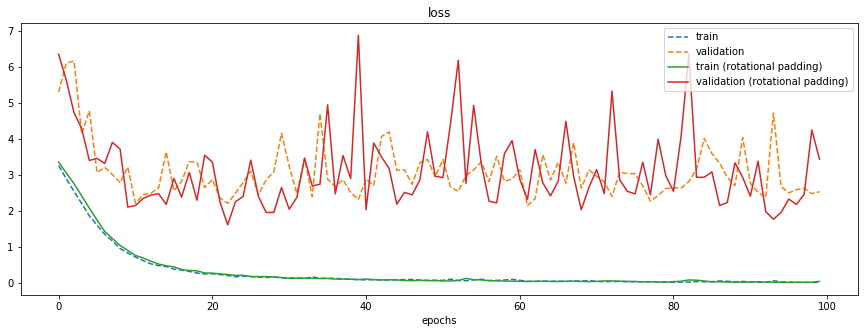

In [69]:
plt.figure(figsize=(15,5))
plt.plot(history_dict['loss'],'--',label='train')
plt.plot(history_dict['val_loss'],'--',label='validation')
plt.plot(history.history['loss'],'-',label='train (rotational padding)')
plt.plot(history.history['val_loss'],'-',label='validation (rotational padding)')
plt.title('loss')
plt.xlabel('epochs')
plt.legend()

Text(0.5, 1.0, 'accuracy')

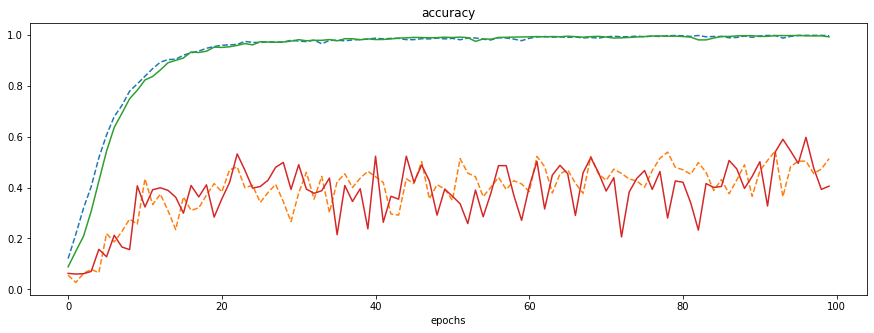

In [70]:
plt.figure(figsize=(15,5))
plt.plot(history_dict['accuracy'],'--',label='train')
plt.plot(history_dict['val_accuracy'],'--',label='validation')
plt.plot(history.history['accuracy'],'-',label='train (rotational padding)')
plt.plot(history.history['val_accuracy'],'-',label='validation (rotational padding)')
plt.xlabel('epochs')
plt.title('accuracy')

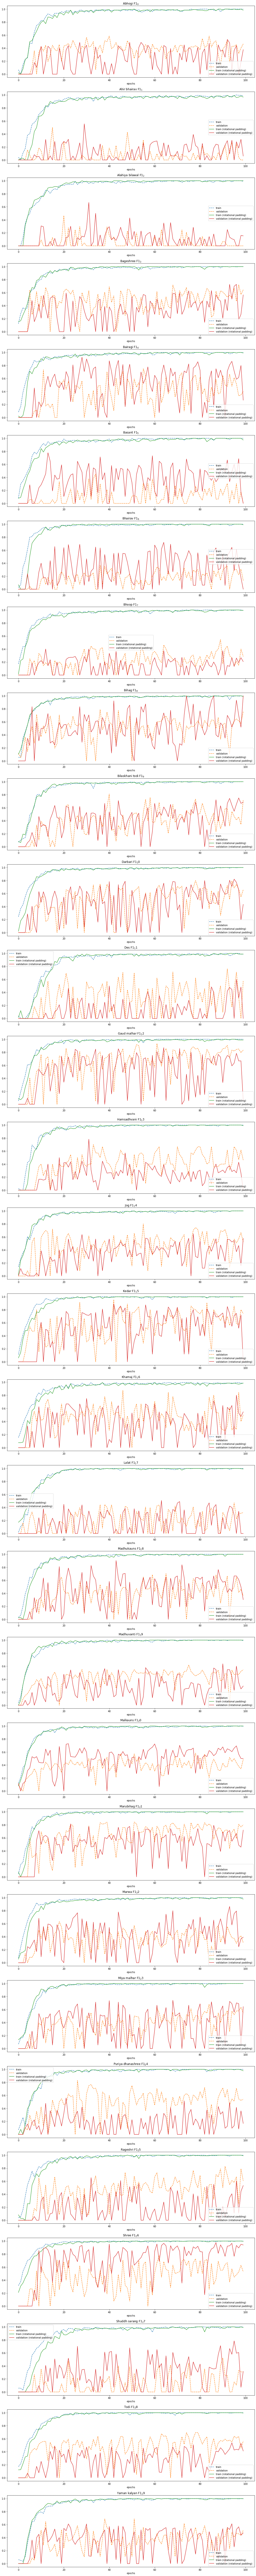

In [71]:
plt.figure(figsize=(15,5*30))
for i in range(30):
    plt.subplot(30,1,i+1)
    plt.plot(history_dict['F1_{}'.format(i)],'--',label='train')
    plt.plot(history_dict['val_F1_{}'.format(i)],'--',label='validation')
    plt.plot(history.history['F1_{}'.format(i)],'-',label='train (rotational padding)')
    plt.plot(history.history['val_F1_{}'.format(i)],'-',label='validation (rotational padding)')
    plt.title(r'{raga_name} F1$_{raga_id}$'.format(raga_id=i,raga_name=ragas_reverse_idx[i]))
    plt.xlabel('epochs')
    plt.legend()
plt.tight_layout()

# work related to periodic padding

In [301]:
a = tf.constant([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])
pre = tf.constant([[0, 0,0,1], [1, 0, 0,0], [0, 1, 0,0], [0, 0, 1,0],[0,0,0,1], [1, 0, 0,0]])
a.shape,pre.shape

(TensorShape([4, 3]), TensorShape([6, 4]))

In [302]:
result=tf.matmul(pre,a)
result

<tf.Tensor: shape=(6, 3), dtype=int32, numpy=
array([[10, 11, 12],
       [ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12],
       [ 1,  2,  3]], dtype=int32)>

In [308]:
a = tf.constant([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])[tf.newaxis,...,tf.newaxis]
pre = tf.constant([[0, 0,0,1], [1, 0, 0,0], [0, 1, 0,0], [0, 0, 1,0],[0,0,0,1], [1, 0, 0,0]])
a.shape,pre.shape

(TensorShape([1, 4, 3, 1]), TensorShape([6, 4]))

In [310]:
tf.transpose(tf.tensordot(pre,a,axes=[1,1]),(1,0,2,3))[0,:,:,0]

<tf.Tensor: shape=(6, 3), dtype=int32, numpy=
array([[10, 11, 12],
       [ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12],
       [ 1,  2,  3]], dtype=int32)>

In [316]:
pre=tf.constant(np.diag(np.ones(12)).take([11,0,1,2,3,4,5,6,7,8,9,10,11,0],axis=0))

In [322]:
class PeriodicPadding(keras.layers.Layer):
    def call(self,x):
        pre=tf.constant(np.diag(np.ones(12)).take([11,0,1,2,3,4,5,6,7,8,9,10,11,0],axis=0),dtype=np.float32)
        return tf.transpose(tf.tensordot(pre,x,axes=[1,1]),(1,0,2,3))

In [323]:
pp=PeriodicPadding()


In [328]:
next(iter(train_data))[0][...,tf.newaxis]

<tf.Tensor: shape=(32, 12, 1500, 1), dtype=float32, numpy=
array([[[[0.35395238],
         [0.62483937],
         [0.2514335 ],
         ...,
         [0.03919563],
         [0.02934529],
         [0.04388006]],

        [[0.8546381 ],
         [1.        ],
         [1.        ],
         ...,
         [0.04332115],
         [0.05731897],
         [0.0764455 ]],

        [[1.        ],
         [0.41365883],
         [0.18235262],
         ...,
         [0.84097314],
         [1.        ],
         [1.        ]],

        ...,

        [[0.26271972],
         [0.18089055],
         [0.0787217 ],
         ...,
         [0.09863921],
         [0.1284486 ],
         [0.08776184]],

        [[0.09208088],
         [0.05293678],
         [0.01514117],
         ...,
         [0.11066498],
         [0.06546266],
         [0.09747966]],

        [[0.15809135],
         [0.20290934],
         [0.01715337],
         ...,
         [0.01311859],
         [0.00853989],
         [0.01680734]]],


 

In [329]:
pp(next(iter(train_data))[0][...,tf.newaxis])

<tf.Tensor: shape=(32, 14, 1500, 1), dtype=float32, numpy=
array([[[[0.00452717],
         [0.00400506],
         [0.00686717],
         ...,
         [1.        ],
         [0.11782621],
         [0.03282115]],

        [[0.00503029],
         [0.00600811],
         [0.01264145],
         ...,
         [0.79746526],
         [0.2563728 ],
         [0.11950074]],

        [[0.01490354],
         [0.0233238 ],
         [0.05875514],
         ...,
         [0.9334802 ],
         [0.6985323 ],
         [0.5537118 ]],

        ...,

        [[0.02656923],
         [0.02724202],
         [0.02169165],
         ...,
         [0.4590119 ],
         [0.10448112],
         [0.02082583]],

        [[0.00452717],
         [0.00400506],
         [0.00686717],
         ...,
         [1.        ],
         [0.11782621],
         [0.03282115]],

        [[0.00503029],
         [0.00600811],
         [0.01264145],
         ...,
         [0.79746526],
         [0.2563728 ],
         [0.11950074]]],


 

In [335]:
c=keras.layers.Conv2D(5,(3,3), padding='valid')

In [336]:
c(pp(next(iter(train_data))[0][...,tf.newaxis]))

<tf.Tensor: shape=(32, 12, 1498, 5), dtype=float32, numpy=
array([[[[-8.96642953e-02,  1.67192012e-01,  1.22336112e-01,
          -1.19068444e-01,  9.58066359e-02],
         [-3.46585698e-02,  7.98996314e-02,  4.03669477e-02,
          -4.02128436e-02,  3.63214836e-02],
         [-2.91647911e-02,  6.70691654e-02,  2.11968012e-02,
          -1.92416068e-02,  2.24674847e-02],
         ...,
         [-1.34937856e-02,  3.23149301e-02, -1.19507752e-01,
           4.22342382e-02, -1.86150316e-02],
         [-2.89242696e-02, -1.16442721e-02, -1.39085233e-01,
           3.14064734e-02, -4.74732667e-02],
         [ 1.53264939e-03, -1.27264662e-02, -1.15292117e-01,
          -2.16421927e-03, -1.15130302e-02]],

        [[-3.63824517e-02, -7.21778767e-03, -6.31002188e-02,
           7.43871881e-03, -7.56851304e-03],
         [-3.52892838e-03,  1.77940354e-02, -3.32056433e-02,
           2.14235857e-03,  1.07655795e-02],
         [-2.26242933e-02,  1.72086544e-02, -5.05561940e-02,
           1.655

Should try the alternate method which is a bit memory heavy compare to the above



In [360]:
a = tf.constant([[1,2,3],[4,5,6],[7,8,9]])[tf.newaxis,...,tf.newaxis]
b = tf.tile(a, [1,3, 1,1])
result = b[:,2:7, :,:]

In [362]:
result[0,:,:,0]

<tf.Tensor: shape=(5, 3), dtype=int32, numpy=
array([[7, 8, 9],
       [1, 2, 3],
       [4, 5, 6],
       [7, 8, 9],
       [1, 2, 3]], dtype=int32)>